In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import IPython.display as ipd
from IPython.display import display
from ponysynth.corpus import *
import numpy
import itertools
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy

In [2]:
luna = sc = SpeechCorpus('/home/celestia/data/audio-tar/Luna.tar')
luna.build_phone_index()

In [3]:
dictionary = open('/opt/mfa/pronunciations_dicts/english.dict.txt').read()

In [4]:
lines = dictionary.split('\n')
phonemes = [x.split()[1:] for x in lines]

phonemes = list(itertools.chain(*phonemes))
phonemes = set(phonemes)

In [117]:
hello = luna.phoneseqs(['HH', 'EH0', 'L', 'OW1'])
hello, rate = hello.cache().sample(1)[0].audio()

ipd.Audio(hello, rate=rate)

In [ ]:
def display_mels(mels, fmax):
    plt.figure(figsize=(15,4))
    librosa.display.specshow(mels, y_axis='mel', fmax=fmax, x_axis='time', sr=rate, hop_length=4)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.show()

import tensorflow as tf
def _log_melspec(pcm, sample_rate):
    """
    Stolen from 
    https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms
    """

    stfts = tf.signal.stft(pcm, frame_length=3200, frame_step=64,
        fft_length=3200)
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
    upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
    spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-8)
    return log_mel_spectrograms

frequency_dense = _log_melspec(hello, rate)
x = frequency_dense.numpy()

print(x.var())
display_mels(frequency_dense.numpy().T - 80, 8000)
time_dense = librosa.feature.melspectrogram(y=hello, sr=rate, fmax=8000, hop_length=4, n_fft=1600)
time_dense = librosa.power_to_db(time_dense, numpy.max)
print(time_dense.var())
display_mels(time_dense, 8000)

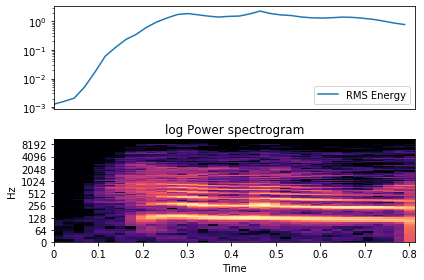

In [124]:
S, phase = librosa.magphase(librosa.stft(hello))
rms = librosa.feature.rms(S=S)

import matplotlib.pyplot as plt
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(rms.T, label='RMS Energy')
plt.xticks([])
plt.xlim([0, rms.shape[-1]])
plt.legend()
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=numpy.max),
                          y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

S = librosa.magphase(librosa.stft(hello, window=numpy.ones, center=False))[0]
librosa.feature.rms(S=S)
plt.show()

(481, 131)

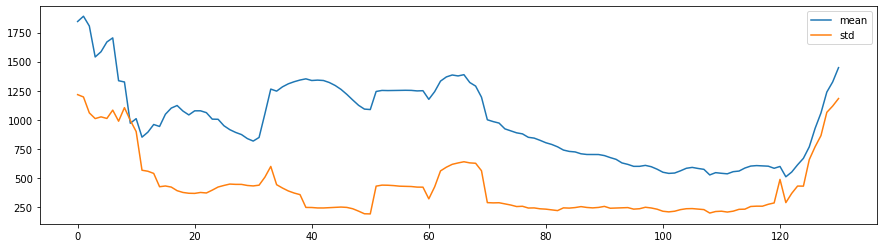

In [209]:
utt = luna.phoneseqs(['HH', 'EH0', 'L', 'OW1']).cache().sample(1)[0].audio()[0]
S = librosa.stft(utt, window=scipy.signal.windows.hann, center=False, hop_length=240, win_length=960, n_fft=960)
pitches, magnitude = librosa.piptrack(S=S, sr=rate)


fig = plt.figure(figsize=(15,4))

weighted_pitches = pitches * magnitude
mean_pitches = weighted_pitches.sum(axis=0) / magnitude.sum(axis=0)
centered_pitches = pitches - mean_pitches
var_pitches = centered_pitches ** 2
std_pitches = numpy.sqrt((var_pitches * magnitude).sum(axis=0) / magnitude.sum(axis=0))

pitches[pitches <= 1] = 10000

plt.plot(mean_pitches, label='mean')
plt.plot(std_pitches, label='std')
plt.legend()
fig.show()
ipd.display(ipd.Audio(utt, rate=rate))
ipd.display(S.shape)


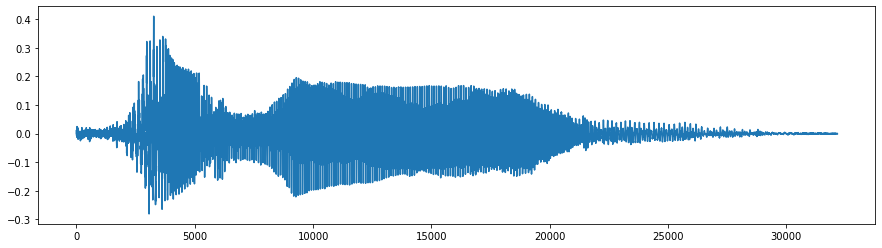

In [191]:
plt.figure(figsize=(15,4))
plt.plot(utt)
plt.show()

display(ipd.Audio(utt, rate=rate, embed=True))

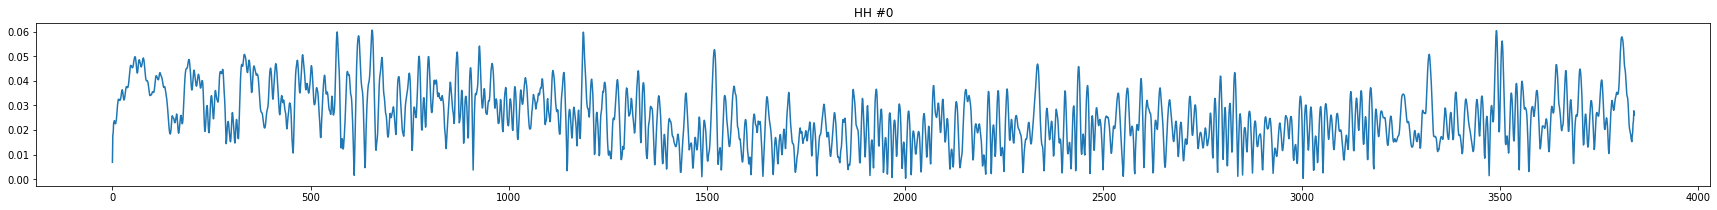

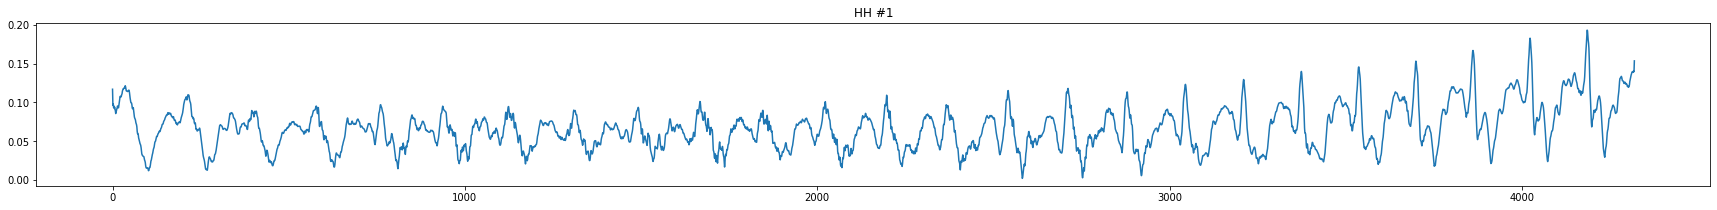

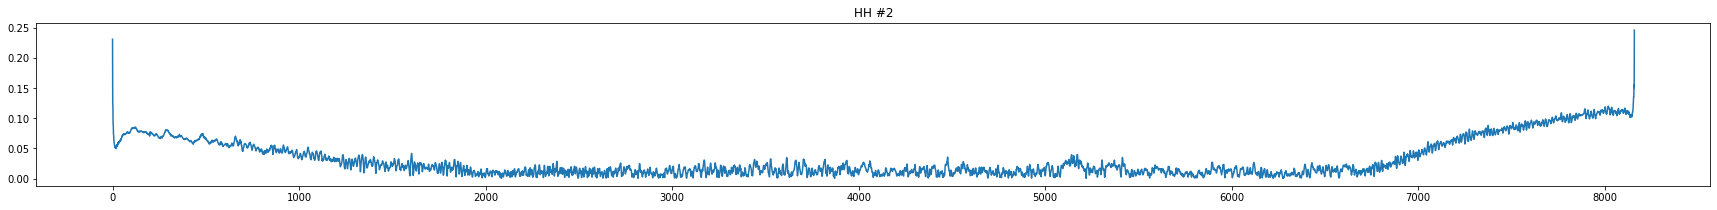

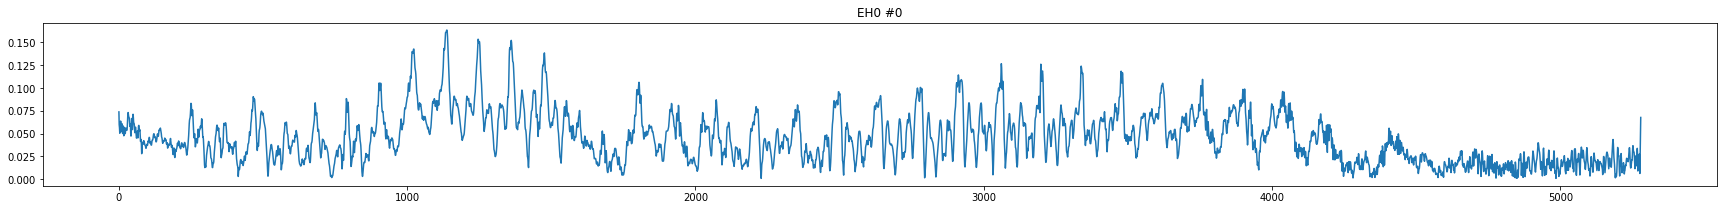

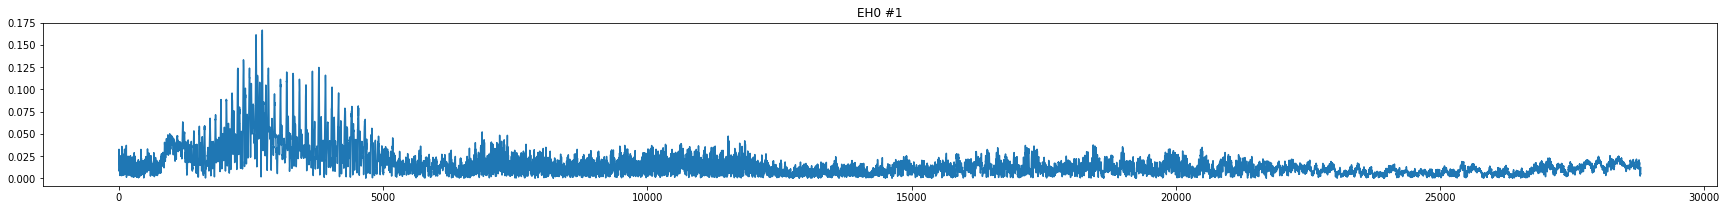

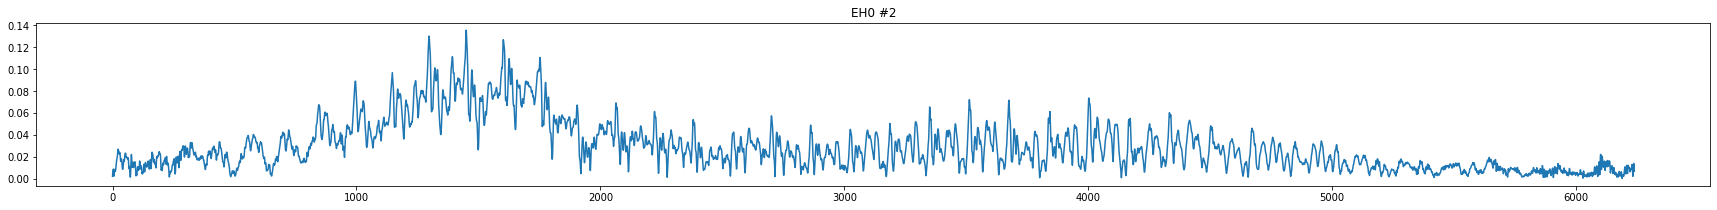

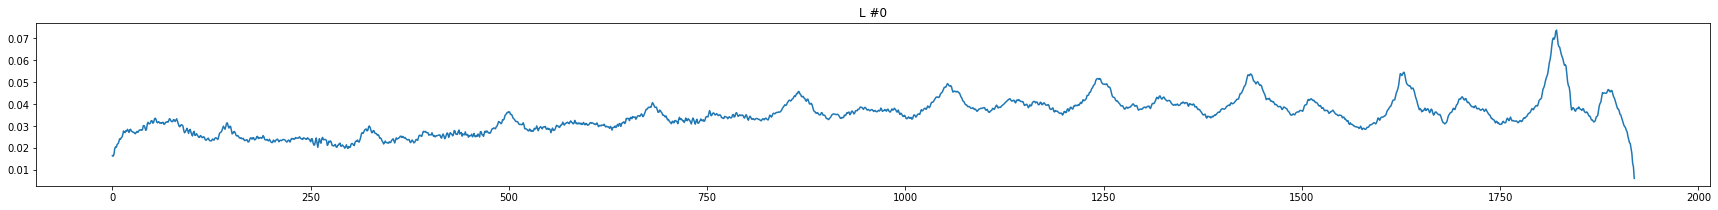

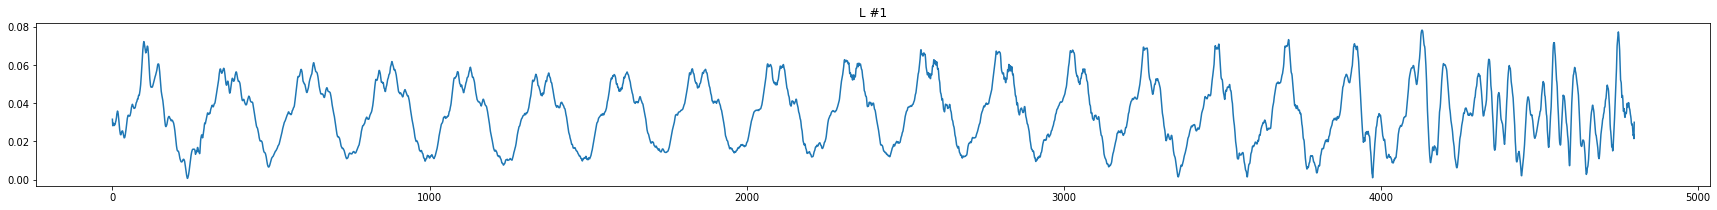

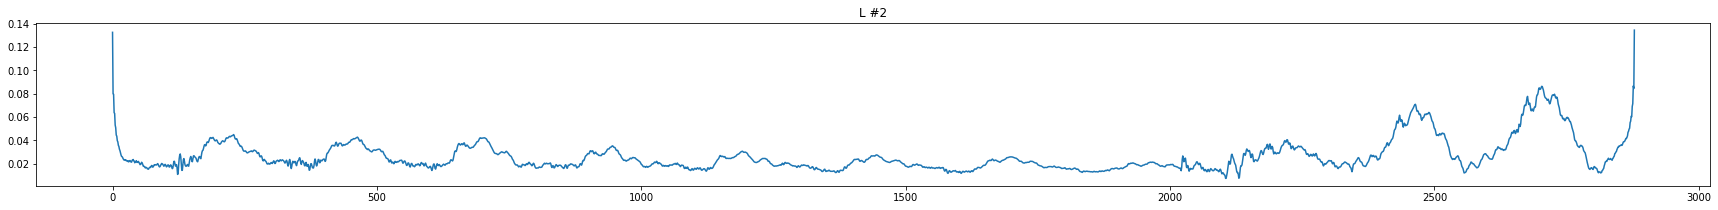

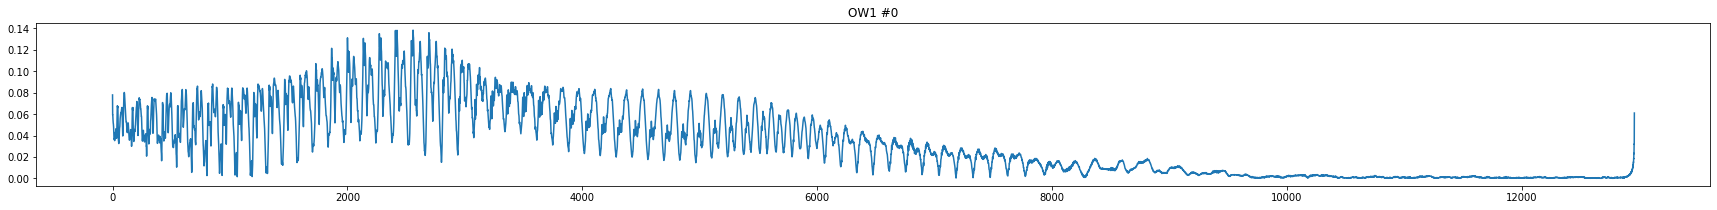

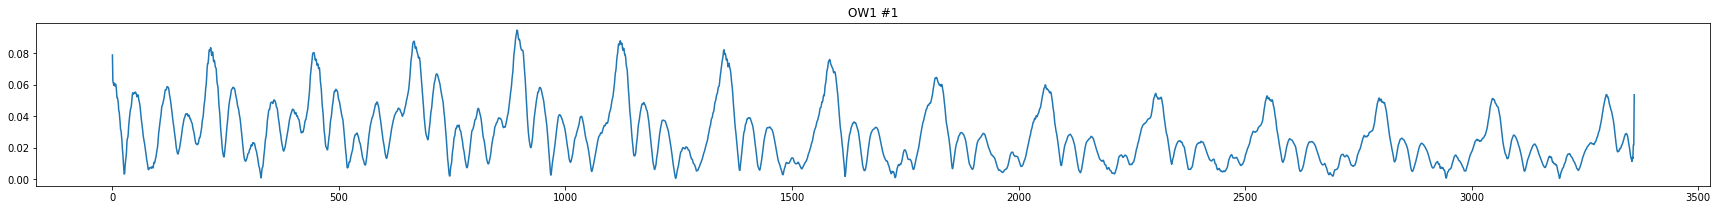

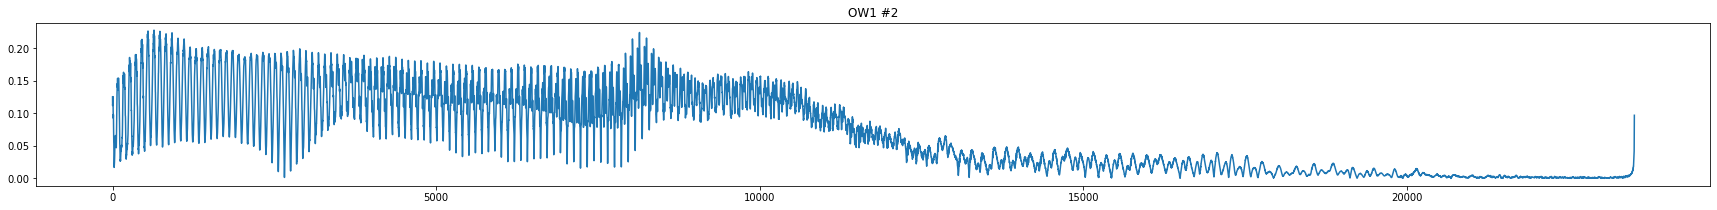

In [9]:
def draw_envelope(envelope, title):
    plt.figure(figsize=(30,3))
    plt.title(title)
    plt.plot(envelope)
    plt.show()
    

for phoneme in ['HH', 'EH0', 'L', 'OW1']:
    for i, phone in enumerate(luna.phoneseqs([phoneme]).cache().sample(3)):
        audio, r = phone.audio()
        analytical_signal = scipy.signal.hilbert(audio)
        envelope = numpy.abs(analytical_signal)
        draw_envelope(envelope, '{} #{}'.format(phoneme, i))
        display(ipd.Audio(audio, rate=rate))


In [10]:
import ponysynth.pyglottal as pyglottal
pyglottal.quick_gci(luna.phoneseqs(['EH0']).cache().sample(1)[0].audio()[0])

(array([ 151,  336,  498,  655,  812,  967, 1124, 1282, 1440, 1542, 1601,
        1701, 1763, 1864, 1928, 2030, 2094, 2199, 2261, 2369, 2432, 2541,
        2607, 2717, 2783, 2889, 2959, 3132, 3305, 3480, 3656, 3832, 4009,
        4188, 4369, 4553, 4742, 4934, 5133, 5172, 5357, 5509, 6233]),)